In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('/home/user01/Data/roads/NNNPedestrian Accidents_translated-Yasir_Laptop.csv')

# Replace unknowns represented by 9 with NaN
df.replace(9, 1, inplace=True)

# Separate features and target
X = df.drop(columns=['Injury_Severity'])
y = df['Injury_Severity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [15]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
catboost_model = CatBoostClassifier(verbose=False)#gpu_ram_part=0.75, task_type='GPU', devices='0')

# Define the parameters for grid search
param_grid = {
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Perform grid search
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=12, verbose=0)
grid_search.fit(X_train_res, y_train_res)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)


/home/user01/anaconda3/envs/road/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters:  {'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [16]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Train the model with the best parameters
best_catboost_model = CatBoostClassifier(**best_params, verbose=False)
best_catboost_model.fit(X_train_res, y_train_res)

# Make predictions
y_pred = best_catboost_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, best_catboost_model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")
print(f"AUC: {auc}")


Accuracy: 0.8975
F1 Score (Micro): 0.8975
F1 Score (Macro): 0.5366053516430731
AUC: 0.6168772190570556


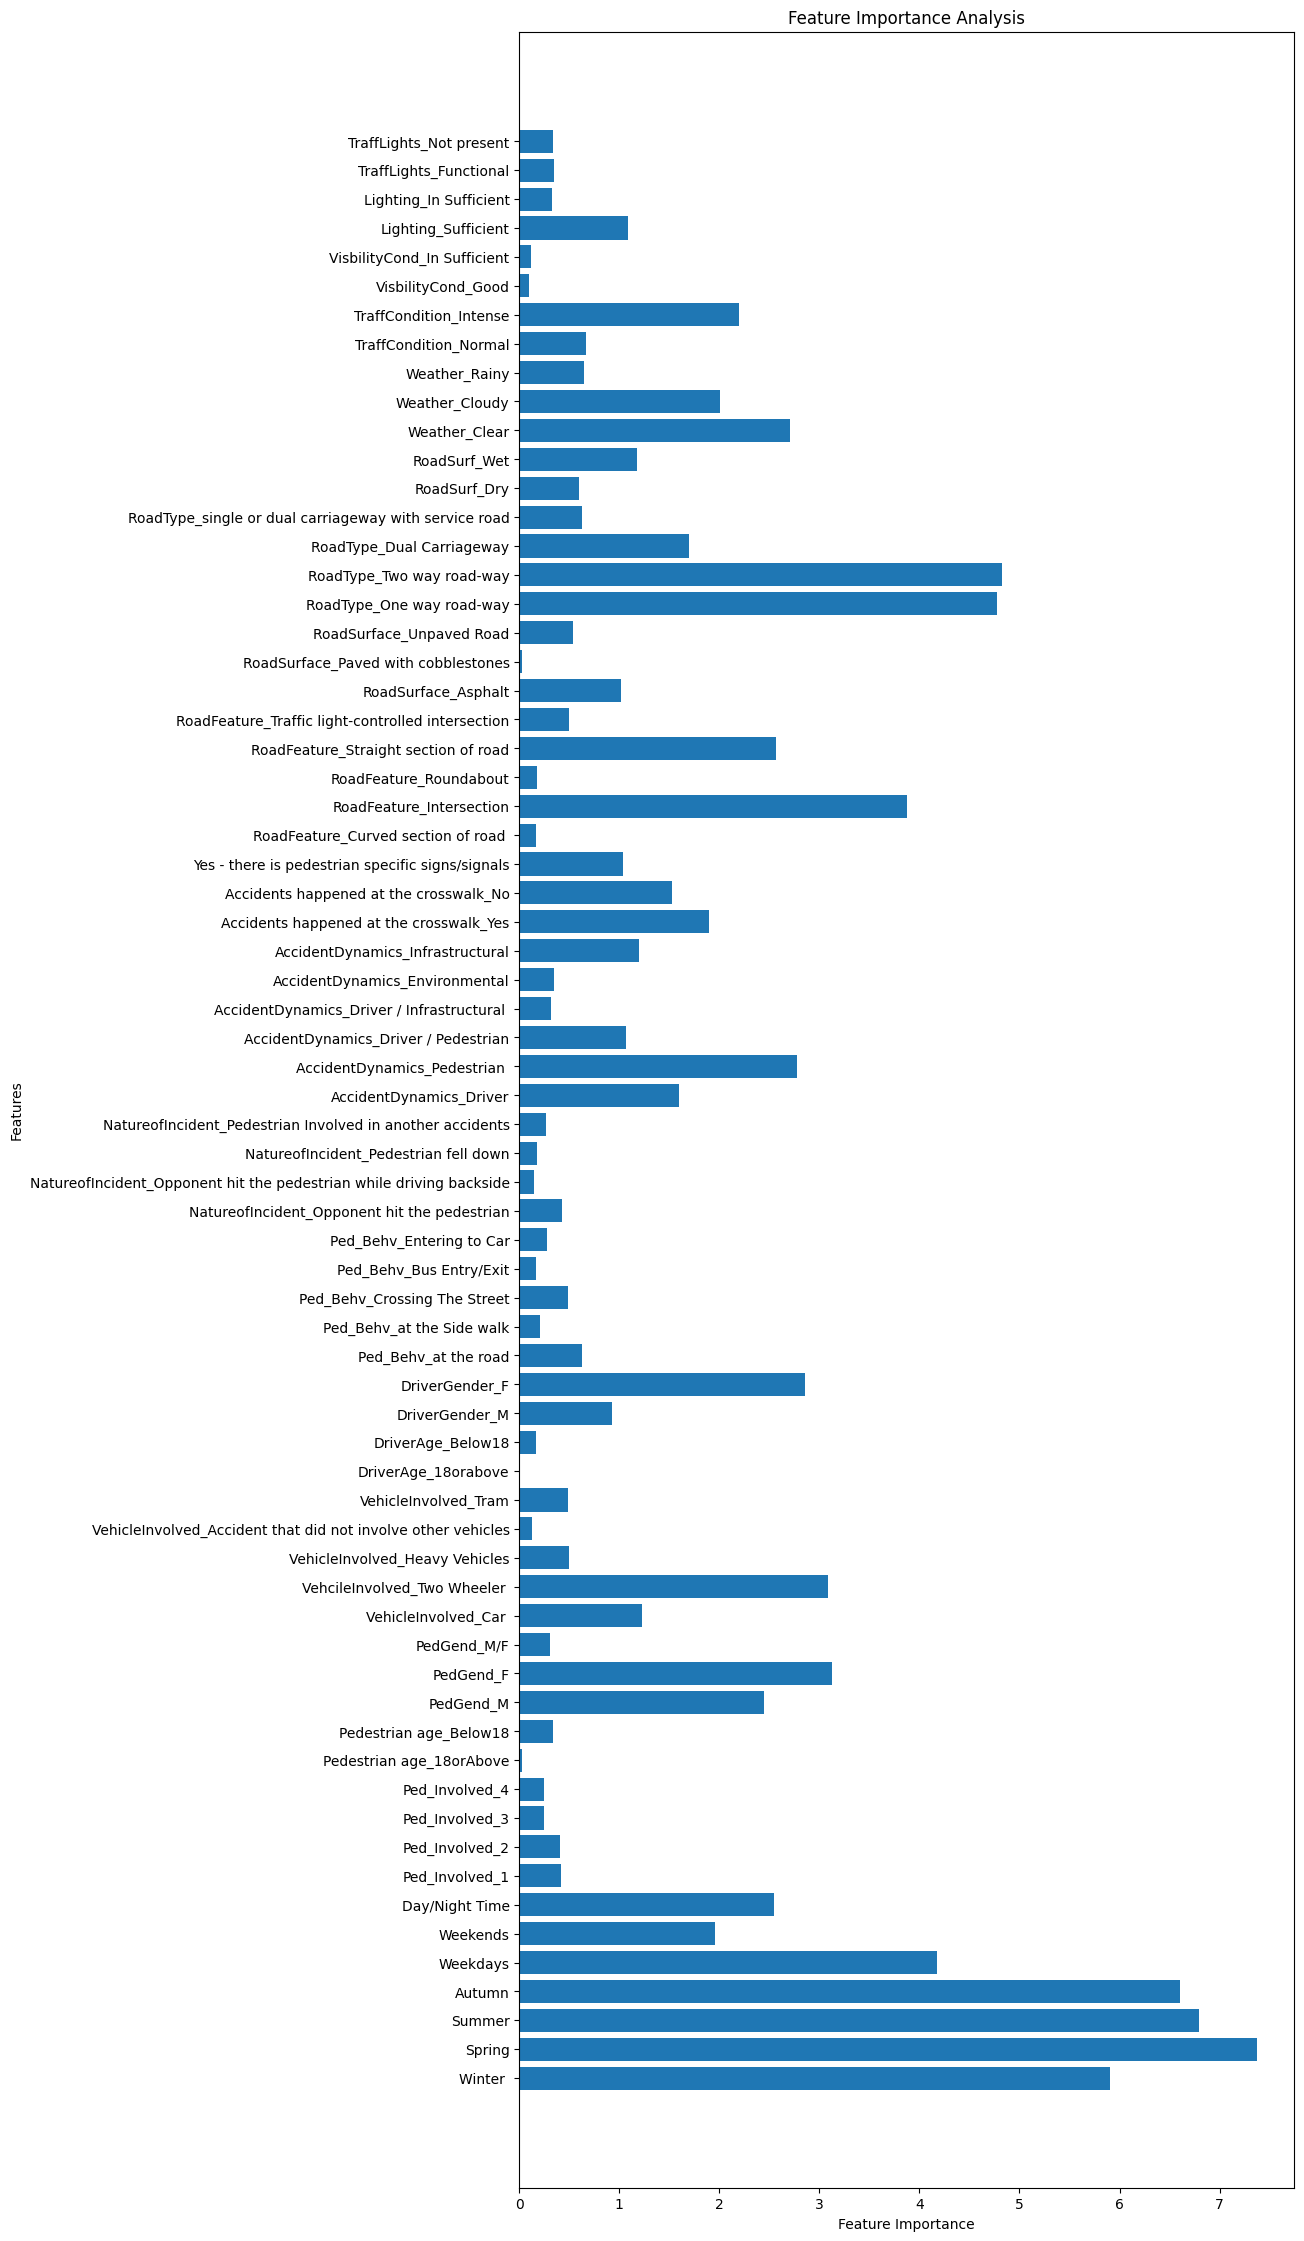

In [17]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importances = best_catboost_model.get_feature_importance()
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 28))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Analysis')
plt.show()


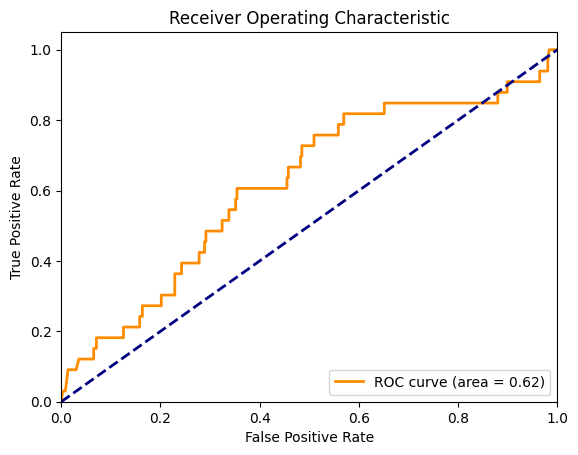

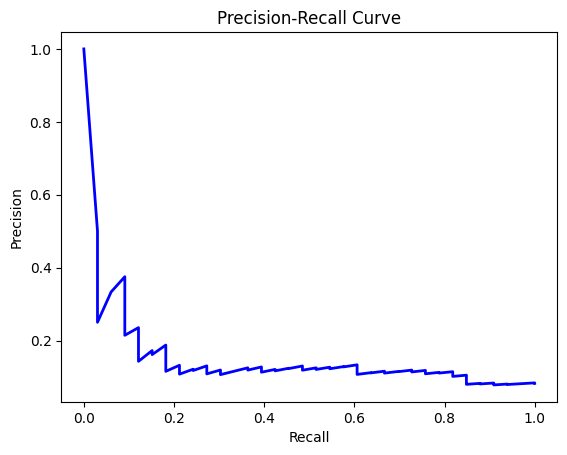

In [18]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Predictions and probabilities
y_pred = best_catboost_model.predict(X_test)
y_proba = best_catboost_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


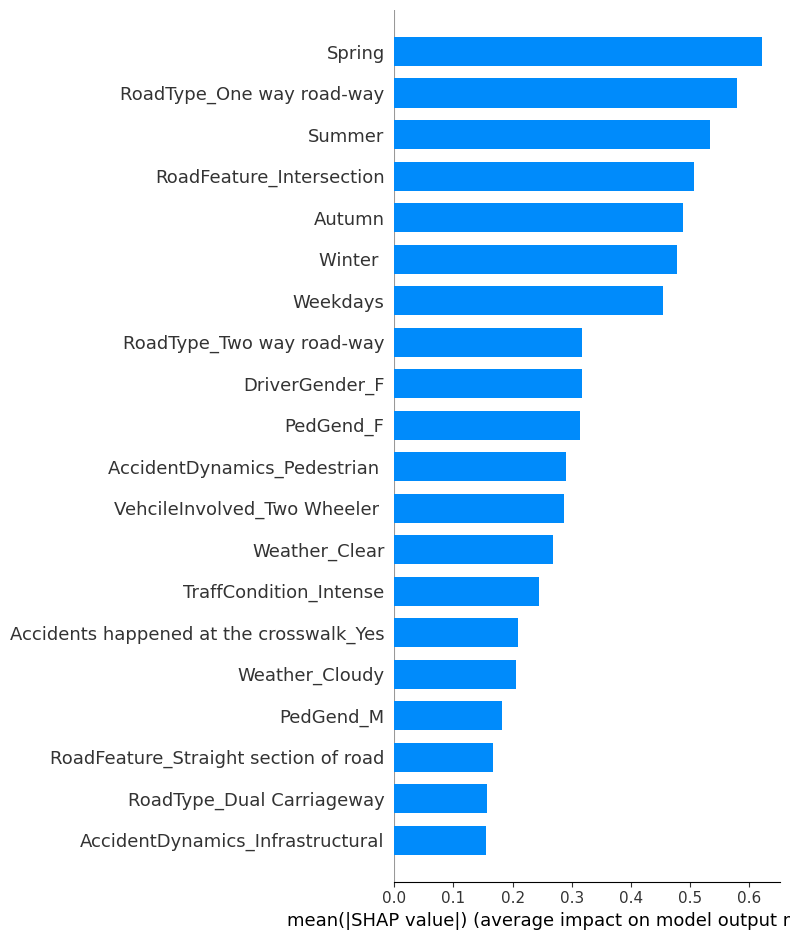

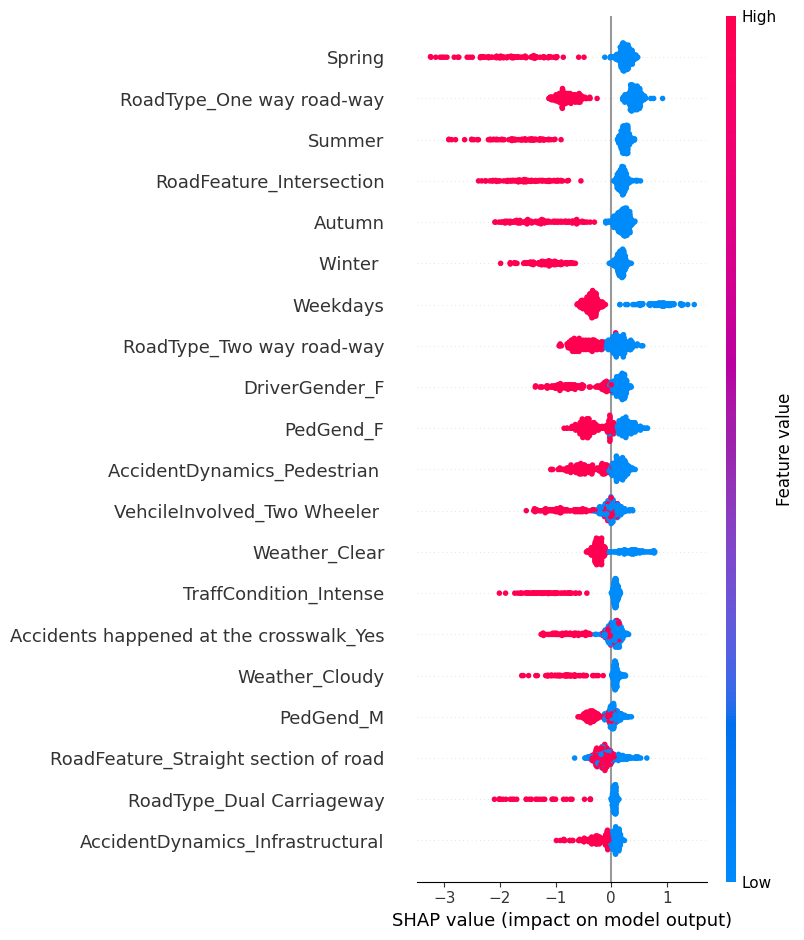

In [19]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_catboost_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


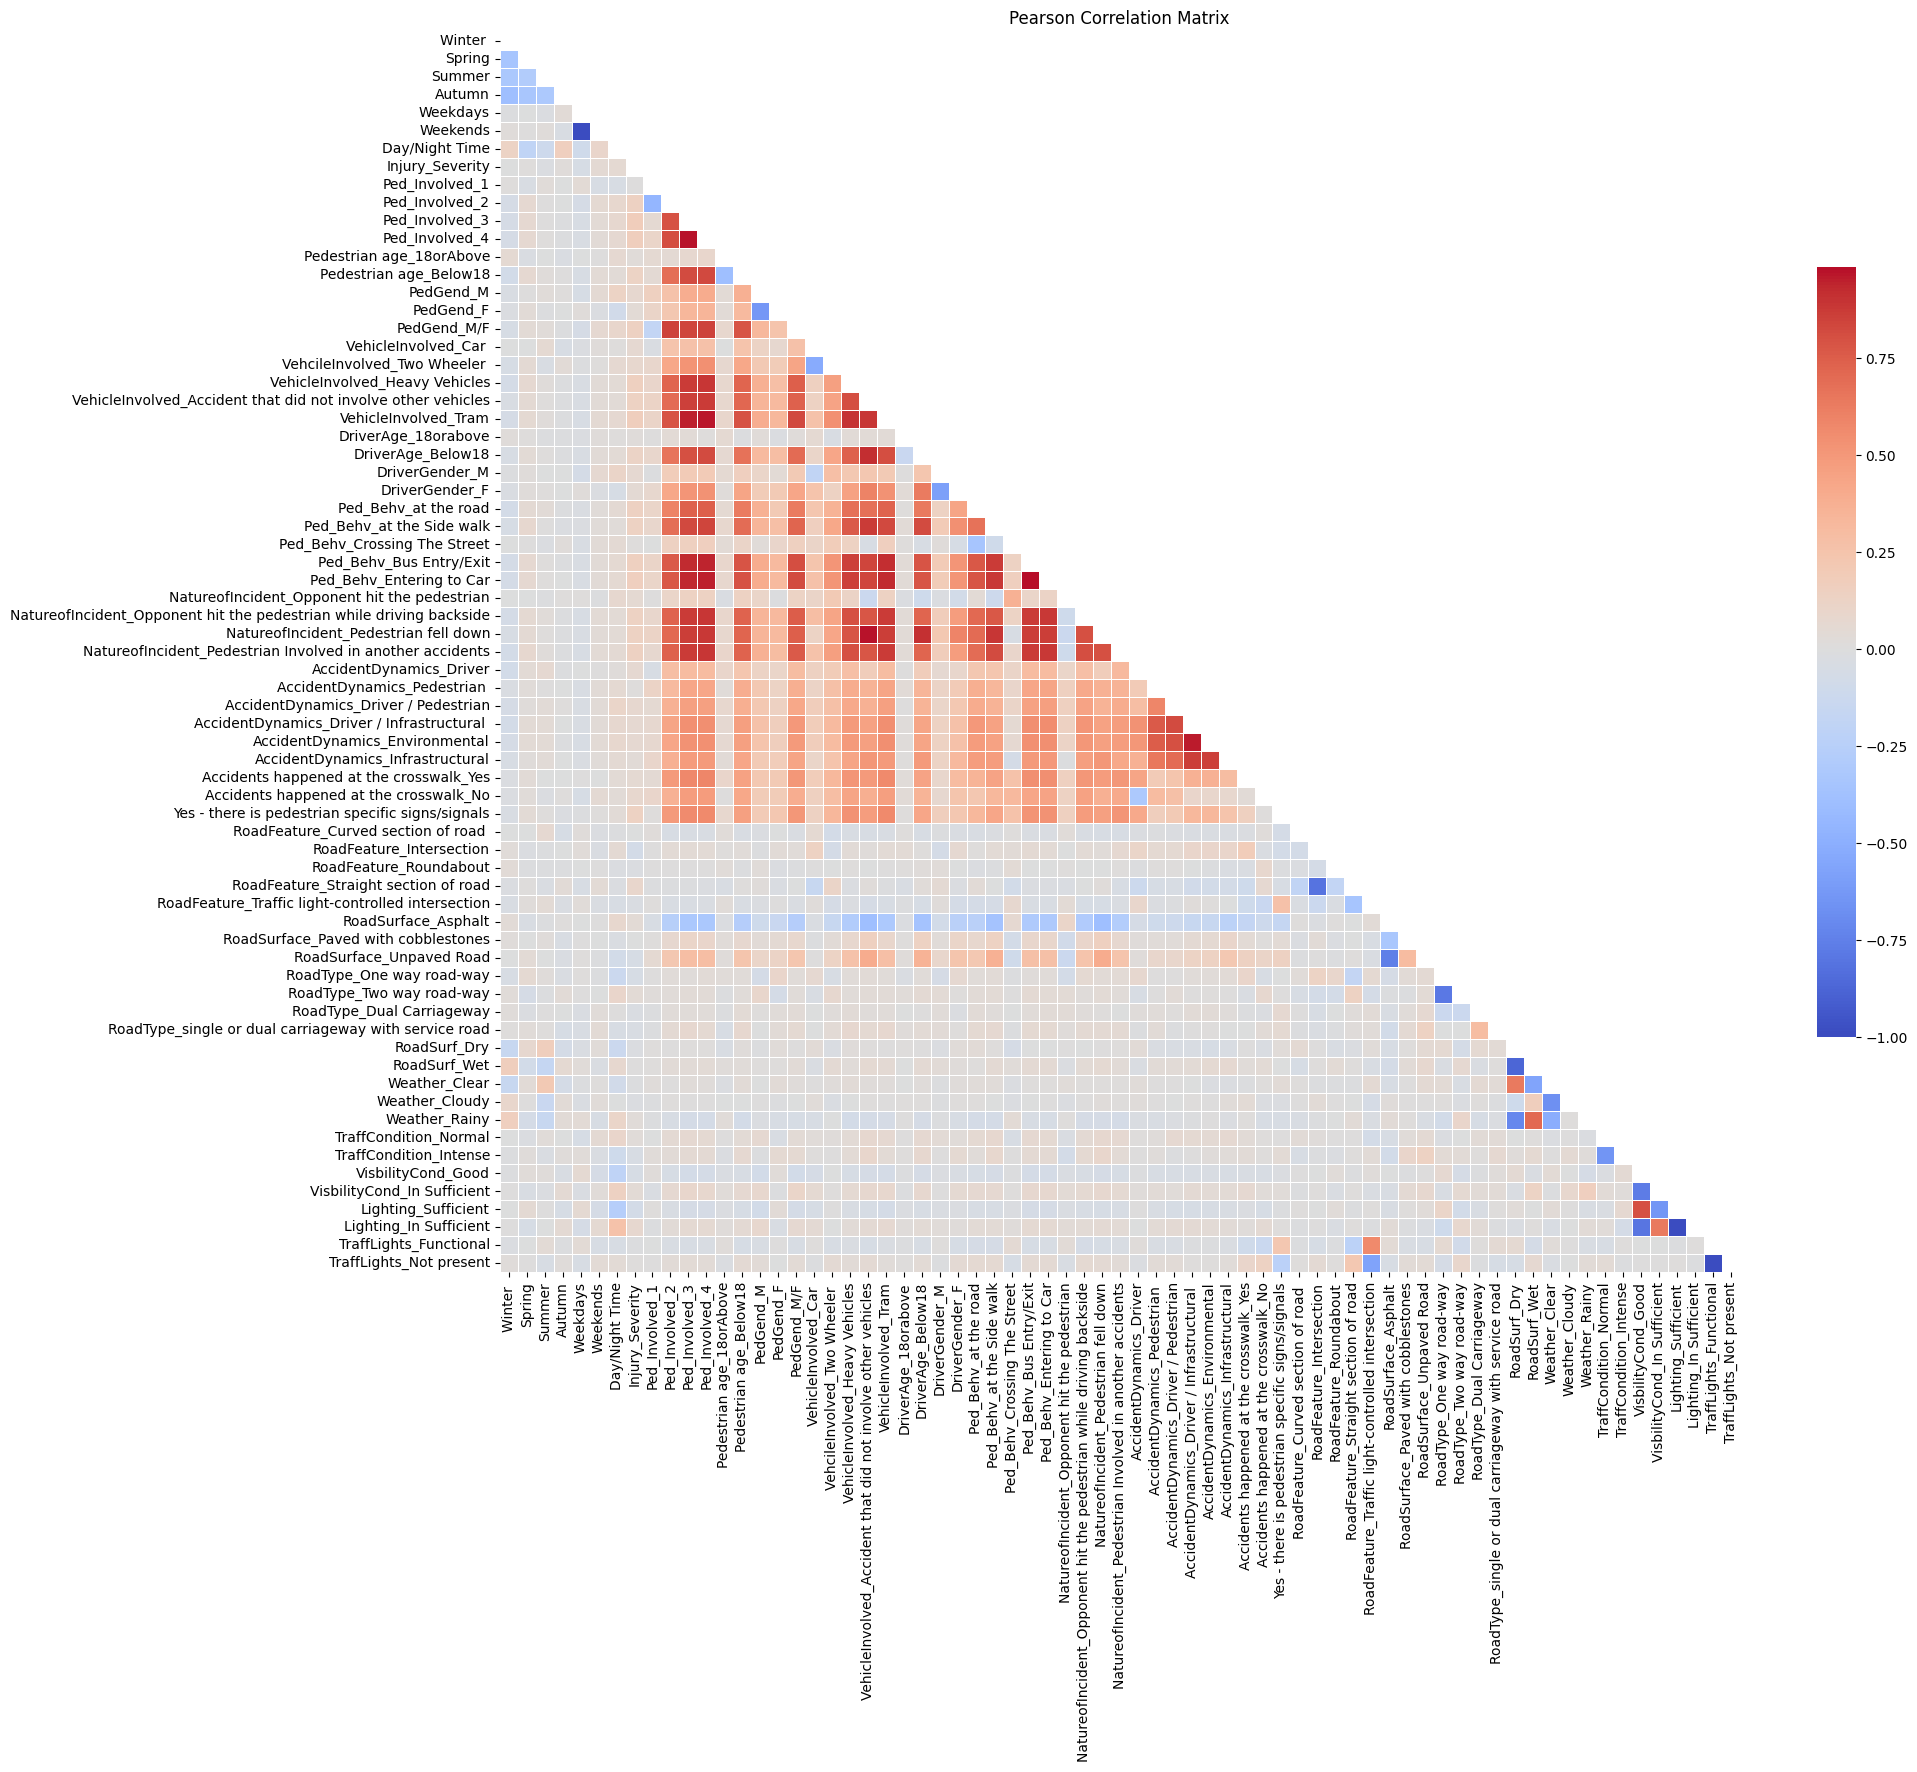

In [20]:
import seaborn as sns
import numpy as np

# Calculate the correlation matrix
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Plot the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Pearson Correlation Matrix')
plt.show()
